In [52]:
# import packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [23]:
# get main directory

main_directory = str(os.getcwd()).strip('notebooks')

In [24]:
# read in cleaned rental properties
rental_data =pd.read_csv(main_directory+'data/curated/rental_properties_cleaned.csv')

In [25]:
# drop irrelevant columns
rental_data.drop(columns = ['Unnamed: 0.1', 'index'], inplace = True)

In [26]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

## feature analysis and selection

In [27]:
# examine the correlation between the internal attributes of rental property; numerical
corr = rental_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,cost_text,beds,baths,parking,under 20 (%),20 - 39 (%),40 - 59 (%),60 +(%)
cost_text,1.000000,0.327619,0.429125,0.168736,-0.064960,-0.020682,0.052148,0.056156
beds,0.327619,1.000000,0.561293,0.498181,0.439415,-0.394344,0.172712,0.190035
baths,0.429125,0.561293,1.000000,0.349729,0.215633,-0.139304,0.078570,0.012851
parking,0.168736,0.498181,0.349729,1.000000,0.344187,-0.352168,0.193757,0.185461
under 20 (%),-0.064960,0.439415,0.215633,0.344187,1.000000,-0.689261,0.491546,0.056000
20 - 39 (%),-0.020682,-0.394344,-0.139304,-0.352168,-0.689261,1.000000,-0.633140,-0.700462
40 - 59 (%),0.052148,0.172712,0.078570,0.193757,0.491546,-0.633140,1.000000,0.103430
60 +(%),0.056156,0.190035,0.012851,0.185461,0.056000,-0.700462,0.103430,1.000000


In [41]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [36]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [37]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [38]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
cfit

,share_flag,property_type
share_flag,1.00,0.07
property_type,0.07,1.00


## preliminary modelling

In [44]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [46]:
# check the fit of the model
fit_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cost_text   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     114.7
Date:                Fri, 16 Sep 2022   Prob (F-statistic):          1.15e-298
Time:                        12:04:42   Log-Likelihood:                -45738.
No. Observations:                6600   AIC:                         9.151e+04
Df Residuals:                    6585   BIC:                         9.161e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        436.6856    111.419      3.919      0.000     218.269     655.103
share_flag[T.1]                                  -98.9762     28.277     -3.500      0.000    -154.408     -43.545
property_type[T.Apartment / Unit / Flat]        -200.5210    110.995     -1.807      0.071    -418.108      17.066
property_type[T.Carspace]                       -434.4105    134.005     -3.242      0.001    -697.104    -171.717
property_type[T.Duplex]                         -344.1598    207.271     -1.660      0.097    -750.479      62.159
property_type[T.House]                          -220.9603    110.908     -1.992      0.046    -438.377      -3.544
property_type[T.New Apartments / Off the Plan]  -261.6727    207.260     -1.263      0.207    -667.970     144.625
property_type[T.Rural]                           166.6649    271.324      0.614      0.539    -365.217     698.547
property_type[T.Semi-Detached]                    -1.1186    150.053     -0.007      0.994    -295.272     293.035
property_type[T.Studio]                         -369.0153    113.736     -3.244      0.001    -591.975    -146.055
property_type[T.Terrace]                          -8.1031    145.114     -0.056      0.955    -292.573     276.367
property_type[T.Townhouse]                      -233.7213    111.184     -2.102      0.036    -451.678     -15.764
property_type[T.Villa]                          -242.2892    124.608     -1.944      0.052    -486.562       1.984
property_type[T.storage unit]                   -411.8010    150.461     -2.737      0.006    -706.753    -116.849
baths                                            198.3247      5.472     36.241      0.000     187.597     209.052
==============================================================================
Omnibus:                     7638.805   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1276670.954
Skew:                           5.881   Prob(JB):                         0.00
Kurtosis:                      70.112   Cond. No.                         264.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

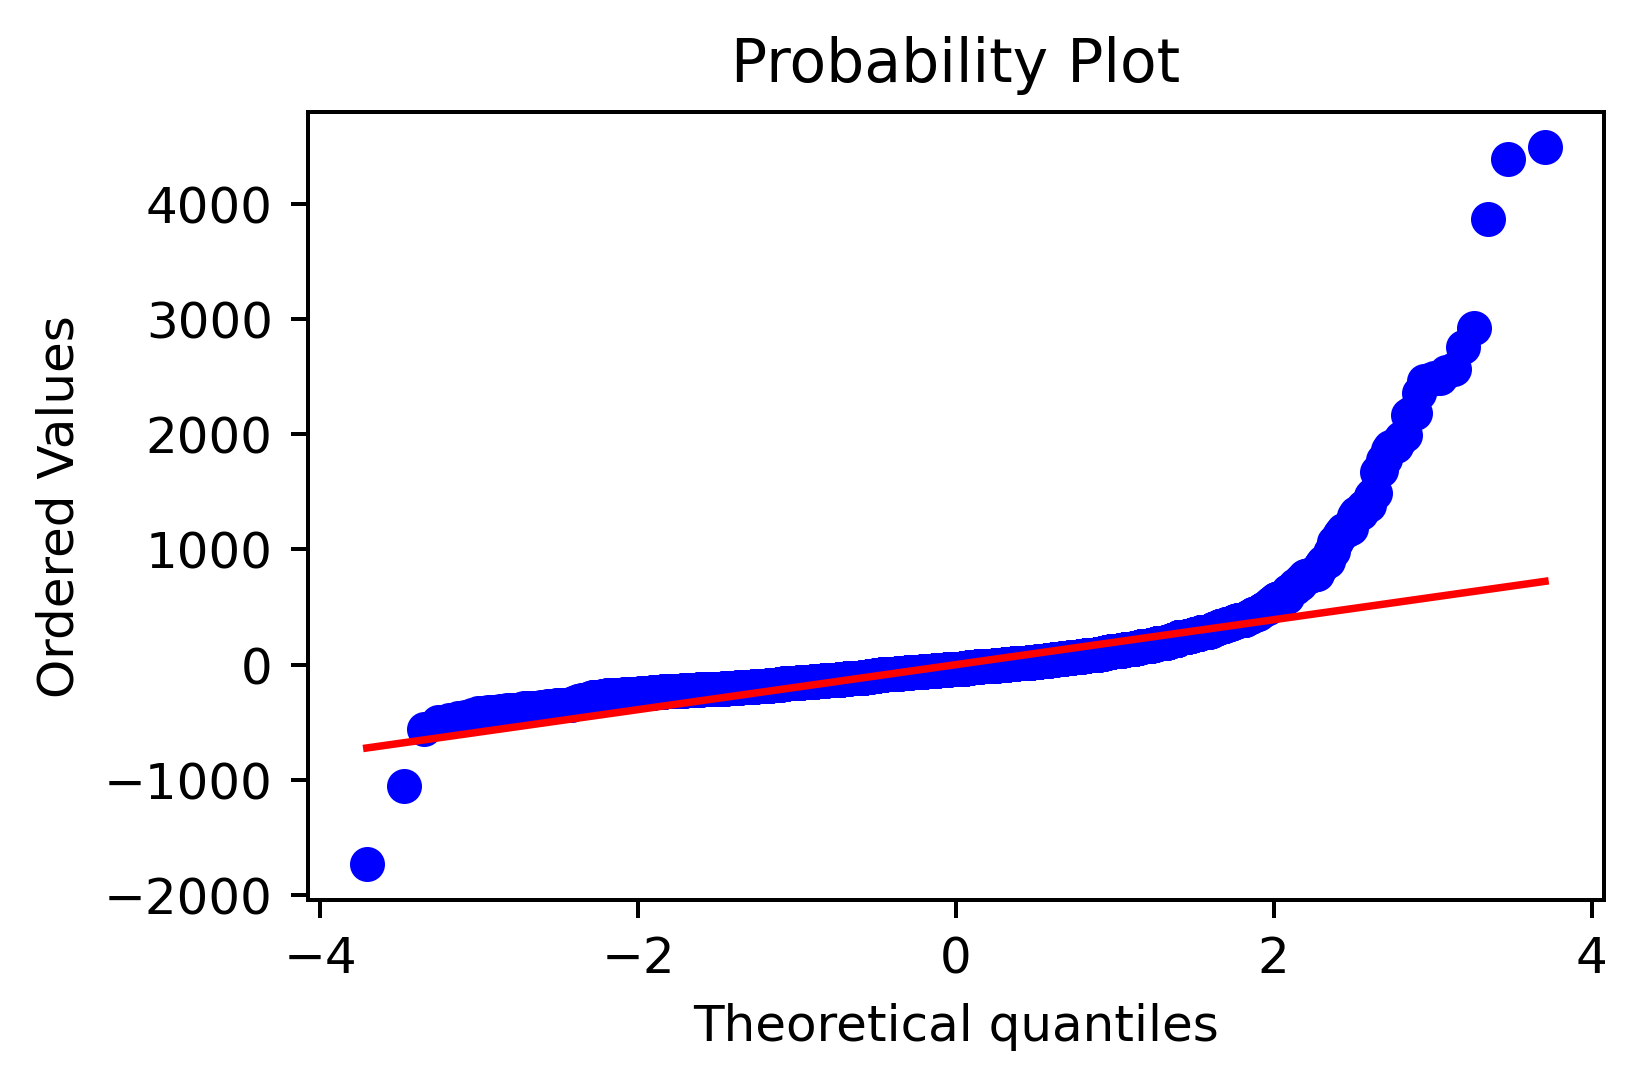

In [50]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)

plt.show()

In [53]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [55]:
fit_NB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              cost_text   No. Observations:                 6600
Model:                            GLM   Df Residuals:                     6585
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47534.
Date:                Fri, 16 Sep 2022   Deviance:                       761.38
Time:                        12:08:37   Pearson chi2:                 1.15e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05325
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          6.1067      0.450     13.567      0.000       5.224       6.989
share_flag[T.1]                                   -0.2288      0.114     -2.002      0.045      -0.453      -0.005
property_type[T.Apartment / Unit / Flat]          -0.3456      0.448     -0.771      0.441      -1.224       0.533
property_type[T.Carspace]                         -2.1528      0.543     -3.967      0.000      -3.217      -1.089
property_type[T.Duplex]                           -0.4729      0.837     -0.565      0.572      -2.114       1.168
property_type[T.House]                            -0.3540      0.448     -0.790      0.429      -1.232       0.524
property_type[T.New Apartments / Off the Plan]    -0.4378      0.838     -0.523      0.601      -2.079       1.204
property_type[T.Rural]                             0.1647      1.096      0.150      0.881      -1.983       2.313
property_type[T.Semi-Detached]                     0.0039      0.606      0.006      0.995      -1.184       1.192
property_type[T.Studio]                           -0.8487      0.459     -1.847      0.065      -1.749       0.052
property_type[T.Terrace]                           0.0057      0.586      0.010      0.992      -1.143       1.155
property_type[T.Townhouse]                        -0.3707      0.449     -0.825      0.409      -1.251       0.510
property_type[T.Villa]                            -0.4256      0.503     -0.845      0.398      -1.412       0.561
property_type[T.storage unit]                     -2.8924      0.613     -4.717      0.000      -4.094      -1.691
baths                                              0.3182      0.022     14.388      0.000       0.275       0.362
==================================================================================================================
"""